In [1]:
!pip install pyarrow
!pip install fastparquet
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.7 MB/s eta 0:00:00


   VendorID  trip_distance  PULocationID  DOLocationID  payment_type  \
0         2           0.00           238            42             2   
3         1           2.90           140            43             1   
4         2           1.23            79           137             1   
5         1           1.20           162           137             1   
6         1           1.80           170            48             1   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ...  pickup_hour  \
0          8.6    1.0      0.5        0.00           0.0  ...            0   
3         15.6    3.5      0.5        4.10           0.0  ...            0   
4          7.2    1.0      0.5        2.44           0.0  ...            0   
5         10.0    3.5      0.5        3.00           0.0  ...            0   
6         12.1    3.5      0.5        3.40           0.0  ...            0   

   dropoff_hour  pickup_month  dropoff_month  distance_miles  trip_duration  \
0             0    

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 76.4min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.5min


Random Forest Validation RMSE: 0.7861490352259343
Random Forest Validation MAE: 0.24096542849227068


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.5min


Random Forest Test RMSE: 0.7893800957489981
Random Forest Test MAE: 0.2420987765775234


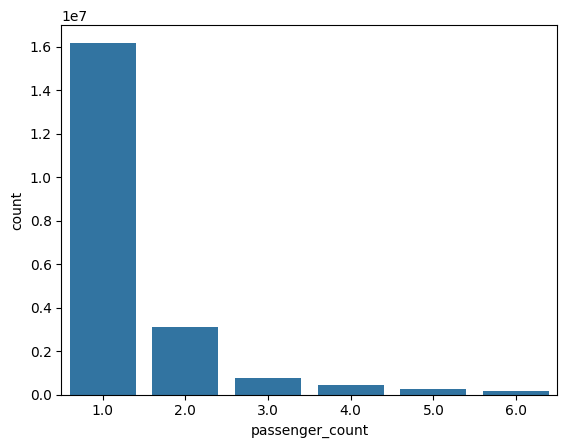

In [3]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class DataLoader:
    def __init__(self, path_prefix):
        self.path_prefix = path_prefix

    def load_data(self):
        """Load and return a subset of the dataset to reduce memory usage."""
        df = pd.read_parquet(self.path_prefix + '/full_df.parquet')
        return df

    def preprocess_data(self, df):
        df = df.copy()
        df = self.encode_and_extend_df(df)
        df = self.encode_days_of_week(df)
        df = self.drop_duplicates(df)
        df = self.distance_calculation(df)
        df = self.drop_columns(df)
        df = self.outlier_correction(df)
        df = self.passenger_count_filter(df)
        df.fillna(0, inplace=True)  # Fill missing values to avoid NaN issues
        self.corr_matrix(df)
        return df

    def encode_and_extend_df(self, df):
        """Encode categorical features."""
        time_of_day_mapping = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Late night': 3}
        if 'pickup_timeofday' in df.columns and 'dropoff_timeofday' in df.columns:
            df['pickup_timeofday_encoded'] = df['pickup_timeofday'].map(time_of_day_mapping)
            df['dropoff_timeofday_encoded'] = df['dropoff_timeofday'].map(time_of_day_mapping)
        else:
            raise ValueError("DataFrame is missing necessary time of day columns.")
        return df

    def encode_days_of_week(self, df):
        """Encode categorical features."""
        day_mapping = {
            'Monday': 0,
            'Tuesday': 1,
            'Wednesday': 2,
            'Thursday': 3,
            'Friday': 4,
            'Saturday': 5,
            'Sunday': 6
        }

        # Check if the necessary columns are in the DataFrame
        if 'pickup_day' in df.columns and 'dropoff_day' in df.columns:
            # Apply the mapping to the DataFrame
            df['pickup_day_encoded'] = df['pickup_day'].map(day_mapping)
            df['dropoff_day_encoded'] = df['dropoff_day'].map(day_mapping)
        else:
            raise ValueError("DataFrame does not contain the 'pickup_day' or 'dropoff_day' columns.")

        # Return the DataFrame with the new columns added
        return df

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        # Earth radius in miles
        R = 3959.0

        # Convert latitude and longitude to radians
        lat1_rad = radians(lat1)
        lon1_rad = radians(lon1)
        lat2_rad = radians(lat2)
        lon2_rad = radians(lon2)

        # Haversine formula
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c

        return distance

    def corr_matrix(self, df):
        corr_matrix = df.corr()
        corr_matrix['fare_amount'].sort_values(ascending=False)

    def distance_calculation(self, df):
        df['orthodromic_distance'] = df.apply(lambda row: self.haversine_distance(
            row['pickup_latitude'], row['pickup_longitude'],
            row['dropoff_latitude'], row['dropoff_longitude']
        ), axis=1)

        return df

    def drop_duplicates(self, df):
        """Drop duplicate rows."""
        df.drop_duplicates(inplace=True)
        return df

    def drop_columns(self, df):
        """Drop unnecessary columns."""
        columns_to_drop = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag',
                           'pickup_timeofday', 'dropoff_timeofday', 'pickup_day', 'dropoff_day',
                           'pickup_datetime', 'dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude',
                           'pickup_longitude', 'pickup_latitude', 'orthodromic_distance']
        df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
        return df

    def outlier_correction(self,df):
        df = df[(df['distance_miles'] > 1.0) & (df['distance_miles'] < 10.0)]
        df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
        return df

    def passenger_count_filter(self, df):
        #We will remove the other passenger counts since they are a minority and only keep records for count=1
        sns.countplot(x=df['passenger_count'])
        df = df[df['passenger_count'] == 1]
        df = df.drop(['passenger_count'], axis=1)
        return df


class DataProcessor:
    def __init__(self, df):
        self.df = df

    def split_data(self, target_col='fare_amount', test_size=0.2, val_size=0.25):
        """Split data into train, validation, and test sets."""
        train_val, test = train_test_split(self.df, test_size=test_size, random_state=42)
        train, val = train_test_split(train_val, test_size=val_size, random_state=42)
        return train, val, test

    def pca_standardize(self, X_train, X_val, X_test, n_components=5):
        """Perform PCA and standardization on the data."""
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_val_pca = pca.transform(X_val_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        return X_train_pca, X_val_pca, X_test_pca

class BaseModel:
    def __init__(self, model):
        self.model = model

    def train(self, X_train, y_train):
        """Train the model with provided training data."""
        self.model.fit(X_train, y_train)

    def predict(self, X):
        """Make predictions with the model."""
        return self.model.predict(X)

    def evaluate(self, y_true, y_pred):
        """Evaluate model performance using RMSE and MAE."""
        return np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)

    def train_model(self, X_train, y_train, X_val, y_val):
        """Train the model and evaluate performance on the validation set."""
        self.train(X_train, y_train)
        y_val_pred = self.predict(X_val)
        val_rmse, val_mae = self.evaluate(y_val, y_val_pred)
        return val_rmse, val_mae

    def test_model(self, X_test, y_test):
        """Test the model and return the RMSE on the test set."""
        y_test_pred = self.predict(X_test)
        test_rmse, test_mae = self.evaluate(y_test, y_test_pred)
        return test_rmse, test_mae

class LinearRegressionModel(BaseModel):
    def __init__(self):
        super().__init__(LinearRegression())

class XGBoostModel(BaseModel):
    def __init__(self):
        super().__init__(xgb.XGBRegressor(n_estimators=200,max_depth=5,learning_rate=0.1,objective='reg:squarederror',n_jobs=-1,random_state=42))

    def grid_search(self, X_train, y_train):
        """Perform Grid Search for hyperparameter tuning."""
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.01],
            'objective': ['reg:squarederror']
        }
        scoring = 'neg_mean_absolute_error'
        n_splits = 5
        kf = KFold(n_splits=n_splits)

        grid_search = GridSearchCV(self.model, param_grid, scoring=scoring, cv=kf, verbose=10)
        grid_search.fit(X_train, y_train)

        self.best_params = grid_search.best_params_
        print("Best hyperparameters:", self.best_params)

        # Update the model with the best parameters
        self.model = xgb.XGBRegressor(**self.best_params, n_jobs=-1, random_state=42)

class RandomForestModel(BaseModel):
    def __init__(self):
        super().__init__(RandomForestRegressor(n_estimators=100, verbose=2))

def main():
    # Load and preprocess data
    data_loader = DataLoader('/app')
    full_df = data_loader.load_data()
    processed_df = data_loader.preprocess_data(full_df)
    print(processed_df.head())
    data_processor = DataProcessor(processed_df)

    # Split data
    train_df, val_df, test_df = data_processor.split_data(target_col='fare_amount')

    # Extract features and target
    target_col = 'fare_amount'
    features = ['distance_miles', 'tolls_amount', 'tip_amount',
                           'pickup_timeofday_encoded', 'dropoff_timeofday_encoded',
                           'trip_distance', 'airport_fee', 'total_amount']

    X_train, y_train = train_df[features], train_df[target_col]
    X_val, y_val = val_df[features], val_df[target_col]
    X_test, y_test = test_df[features], test_df[target_col]

    # Standardize and perform PCA
    X_train_pca, X_val_pca, X_test_pca = data_processor.pca_standardize(X_train, X_val, X_test)

    # Linear Regression Model
    linear_regression_model = LinearRegressionModel()

    # Train and evaluate Linear Regression model
    val_rmse_lr, val_mae_lr = linear_regression_model.train_model(X_train, y_train, X_val, y_val)

    print(f'Linear Regression Validation RMSE: {val_rmse_lr}')
    print(f'Linear Regression Validation MAE: {val_mae_lr}')

    # Test model - Linear Regression
    test_rmse_lr, test_mae_lr = linear_regression_model.test_model(X_test, y_test)

    print(f'Linear Regression Test RMSE: {test_rmse_lr}')
    print(f'Linear Regression Test MAE: {test_mae_lr}')

    #XGBoost Model with PCA
    xgboost_model = XGBoostModel()

    # Train and evaluate XGBoost model
    val_rmse_xgb, val_mae_xgb = xgboost_model.train_model(X_train_pca, y_train, X_val_pca, y_val)

    print(f'XGBoost Validation RMSE: {val_rmse_xgb}')
    print(f'XGBoost Validation MAE: {val_mae_xgb}')

    # Test model - XGBoost
    test_rmse_xgb, test_mae_xgb = xgboost_model.test_model(X_test_pca, y_test)

    print(f'XGBoost Test RMSE: {test_rmse_xgb}')
    print(f'XGBoost Test MAE: {test_mae_xgb}')

    #XGBoost Model with PCA and grid search hyperparameter tuning
    xgboost_model_gs = XGBoostModel()

    # Perform grid search
    xgboost_model_gs.grid_search(X_train_pca, y_train)

    # Train and evaluate XGBoost model after GridSearch
    val_rmse_xgb_gs, val_mae_xgb_gs = xgboost_model_gs.train_model(X_train_pca, y_train, X_val_pca, y_val)

    print(f'XGBoost after Grid Search Validation RMSE: {val_rmse_xgb_gs}')
    print(f'XGBoost after Grid Search Validation MAE: {val_mae_xgb_gs}')

    # Test model - XGBoost after GridSearch
    test_rmse_xgb_gs, test_mae_xgb_gs = xgboost_model_gs.test_model(X_test_pca, y_test)

    print(f'XGBoost after Grid Search Test RMSE: {test_rmse_xgb_gs}')
    print(f'XGBoost after Grid Search Test MAE: {test_mae_xgb_gs}')

    # Random Forest after PCA

    rf_model = RandomForestModel()

    # Train and evaluate XGBoost model
    val_rmse_rf, val_mae_rf = rf_model.train_model(X_train_pca, y_train, X_val_pca, y_val)

    print(f'Random Forest Validation RMSE: {val_rmse_rf}')
    print(f'Random Forest Validation MAE: {val_mae_rf}')

    # Test model - Random Forest
    test_rmse_rf, test_mae_rf = rf_model.test_model(X_test_pca, y_test)

    print(f'Random Forest Test RMSE: {test_rmse_rf}')
    print(f'Random Forest Test MAE: {test_mae_rf}')

if __name__ == "__main__":
    main()